# Contrastive Learning with MNIST Using Pytorch

In [1]:
import os
import time

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from tqdm import tqdm
import optuna

import torch
import torchvision
from torch import nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms, models
from torch.optim.lr_scheduler import StepLR

## GPU Setup (Optional)

In [2]:
torch.__version__
# '1.13.0+cu117'

'1.13.0+cu117'

In [3]:
# Get info of all GPU devices
!nvidia-smi

Fri Jul  7 17:33:03 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 536.23                 Driver Version: 536.23       CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3060      WDDM  | 00000000:22:00.0 Off |                  N/A |
|  0%   47C    P8              14W / 170W |      0MiB / 12288MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [4]:
# Set environment variable with possible device ids
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"
print(os.environ["CUDA_VISIBLE_DEVICES"])
# Set device: 0 or 1
# NOTE: indices are not necessarily the ones shown by nvidia-smi
# We need to try them with the cell below
torch.cuda.set_device("cuda:0")

0,1


In [5]:
# Check that the selected device is the desired one
print("Torch version?", torch.__version__)
print("Torchvision version?", torchvision.__version__)
print("Is cuda available?", torch.cuda.is_available())
print("Is cuDNN version:", torch.backends.cudnn.version())
print("cuDNN enabled? ", torch.backends.cudnn.enabled)
print("Device count?", torch.cuda.device_count())
print("Current device?", torch.cuda.current_device())
print("Device name? ", torch.cuda.get_device_name(torch.cuda.current_device()))
x = torch.rand(5, 3)
print(x)

Torch version? 1.13.0+cu117
Torchvision version? 0.14.0+cu117
Is cuda available? True
Is cuDNN version: 8500
cuDNN enabled?  True
Device count? 1
Current device? 0
Device name?  NVIDIA GeForce RTX 3060
tensor([[0.8922, 0.5638, 0.0425],
        [0.6749, 0.2590, 0.7286],
        [0.4643, 0.6446, 0.2752],
        [0.3932, 0.7982, 0.8686],
        [0.2315, 0.2083, 0.2703]])


## Config and Dataset

In [6]:
# Configuration class
class Config:
    def __init__(self):
        # Hyperparameters
        # Best hyperparameters: {'lr': 0.00010421719087358276, 'weight_decay': 1.0889499856024069e-08}
        self.learning_rate = 0.001 # 0.00010421719087358276
        self.num_epochs = 200
        self.batch_size = 64
        self.patience = 100 # For early stopping
        self.dropout_p = 0.3
        self.weight_decay = 1e-5 # 1.0889499856024069e-08
        self.embedding_size = 32 # Size of the embedding/feature vectors
        self.scheduler_step_size = 70  # Step size for the learning rate scheduler
        self.scheduler_gamma = 0.3  # Gamma for the learning rate scheduler: every step_size lr is multiplied by gamma
        # Other application variables
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        #self.device = torch.device("cpu")
        self.base_path = "./output"
        os.makedirs(self.base_path, exist_ok=True)  # Create the base_path directory if it doesn't exist
        self.best_model_path = os.path.join(self.base_path, "best_model.pth")
        self.last_model_path = os.path.join(self.base_path, "last_model.pth")
        self.learning_plot_path = os.path.join(self.base_path, "learning_curves.png")
        self.threshold_plot_path = os.path.join(self.base_path, "threshold_histogram.png")

In [7]:
# Dataset generator class
class PairDataset(Dataset):
    def __init__(self, dataset):
        self.dataset = dataset
        self.pairs = self._make_pairs()

    def _make_pairs(self):
        # initialize an empty list to hold the image pairs and labels
        pairs = []

        # calculate the total number of classes present in the dataset
        # and then build a list of indexes for each class label that
        # provides the indexes for all examples with a given label
        # NOTE self.dataset.dataset accesses to the entire dataset
        # self.dataset.indices contains the indices of the Subset/current split
        #num_classes = len(np.unique(self.dataset.dataset.targets[self.dataset.indices]))
        num_classes = len(np.unique(self.dataset.dataset.targets)) # classes in ENTIRE dataset
        # Indices per class in SUBSET
        indices = [np.where(self.dataset.dataset.targets[self.dataset.indices] == i)[0] for i in range(num_classes)]
        # Negative indices per class in SUBSET: indices of images of different class
        neg_indices = [np.where(self.dataset.dataset.targets[self.dataset.indices] != i)[0] for i in range(num_classes)]

        # loop over all images
        for idx_a in range(len(self.dataset)):
            # grab the current image and label belonging to the current iteration
            _, label = self.dataset[idx_a]

            # randomly pick an image that belongs to the *same* class label
            idx_b = np.random.choice(indices[label])
            pos_image_idx = idx_b

            # prepare a positive pair and update the pairs list with the indices and label
            pairs.append((idx_a, pos_image_idx, 1))

            # grab the indices for each of the class labels *not* equal to the current label
            # and randomly pick an image corresponding to a label *not* equal to the current label
            #neg_indices = np.where(self.dataset.targets != label)[0]
            #neg_indices = np.where(self.dataset.dataset.targets != label)[0]
            #neg_image_idx = np.random.choice(neg_indices)
            neg_image_idx = np.random.choice(neg_indices[label])

            # prepare a negative pair of images and update the pairs list with the indices and label
            pairs.append((idx_a, neg_image_idx, 0))

        return pairs

    def __getitem__(self, index):
        img1_idx, img2_idx, label = self.pairs[index]
        img1, label1 = self.dataset[img1_idx]
        img2, label2 = self.dataset[img2_idx]
        assert (label1 == label2) == bool(label)
        return img1, img2, torch.tensor(int(label1 == label2), dtype=torch.float32)
    
    def __len__(self):
        return len(self.pairs)

## Model

In [8]:
# Siamese Network
class SiameseNetworkResnet(nn.Module):
    def __init__(self, embedding_size=128, dropout_p=0.3, freeze_backbone=False):
        super(SiameseNetwork, self).__init__()
        #self.backbone = models.resnet18(pretrained=True)
        self.backbone = models.resnet18(weights='ResNet18_Weights.DEFAULT')
        self.embedding_size = embedding_size
        self.dropout_p = dropout_p

        # Remove the fully connected layer
        self.backbone = nn.Sequential(*list(self.backbone.children())[:-1])

        if freeze_backbone:
            for param in self.backbone.parameters():
                param.requires_grad = False

        self.head = nn.Sequential(
            #nn.Linear(self.backbone[-1].out_features, 512),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(self.dropout_p),
            nn.Linear(256, self.embedding_size)
        )

    def forward_one(self, x):
        x = self.backbone(x)
        x = x.view(x.size()[0], -1)
        x = self.head(x)
        return x

    def forward(self, input1, input2):
        output1 = self.forward_one(input1)
        output2 = self.forward_one(input2)
        return output1, output2

class SiameseNetwork(nn.Module):
    def __init__(self, embedding_size=48, dropout_p=0.3):
        super(SiameseNetwork, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, padding=1) # k=2: 28 -> 29; k=3: 28 -> 28
        self.pool1 = nn.MaxPool2d(2, 2) # 29/2 -> 14
        self.dropout1 = nn.Dropout(0.3)

        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.dropout2 = nn.Dropout(0.3)

        self.fc = nn.Linear(64, embedding_size)  # if adaptive_avg_pool2d used below
        #self.fc = nn.Linear(64*7*7, embedding_size) # 28/2/2 = 7

        # Apply Xavier initialization
        nn.init.xavier_uniform_(self.conv1.weight)
        nn.init.xavier_uniform_(self.conv2.weight)
        nn.init.xavier_uniform_(self.fc.weight)
    
    def forward_one(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = self.dropout1(x)

        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = self.dropout2(x)

        x = F.adaptive_avg_pool2d(x, (1, 1))
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = self.fc(x)
        return x

    def forward(self, input1, input2):
        output1 = self.forward_one(input1)
        output2 = self.forward_one(input2)
        return output1, output2
        
# Contrastive loss
class ContrastiveLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        # pairwise_distance(): equivalent to euclidean_distance:
        # torch.sqrt(((output1 - output2) ** 2).sum(dim=1))
        euclidean_distance = F.pairwise_distance(output1, output2)
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))
        return loss_contrastive

In [ ]:
model = SiameseNetwork()
print(model)

## Utils

In [9]:
# Save model function
def save_model(model, save_path):
    torch.save(model.state_dict(), save_path)

# Load model function
def load_model(model, load_path, device):
    model.load_state_dict(torch.load(load_path, map_location=device))
    return model

In [10]:
# Plot training function
def plot_training(train_loss_history, val_loss_history, config):
    plt.figure(figsize=(10, 5))
    plt.plot(train_loss_history, label='Train Loss')
    plt.plot(val_loss_history, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig(config.learning_plot_path)
    plt.show()
    
# Prediction function
def predict(model, img1, img2, device="cpu"):
    model.eval()
    model.to(device)
    img1, img2 = img1.to(device), img2.to(device)
    with torch.no_grad():
        output1, output2 = model(img1, img2)
        distances = F.pairwise_distance(output1, output2).to("cpu").numpy()
        return distances

# Plot prediction function
def plot_prediction(img1, img2, distances, limit=None):
    if limit is not None:
        img1, img2, distances = img1[:limit], img2[:limit], distances[:limit]

    fig, axs = plt.subplots(len(img1), 2, figsize=(5, 3*len(img1)))
    for i in range(len(img1)):
        img1_i = img1[i].squeeze().permute(1, 2, 0) if img1[i].shape[0] == 3 else img1[i].squeeze()
        img2_i = img2[i].squeeze().permute(1, 2, 0) if img2[i].shape[0] == 3 else img2[i].squeeze()
        cmap1 = 'gray' if img1[i].shape[0] == 1 else None
        cmap2 = 'gray' if img2[i].shape[0] == 1 else None
        axs[i, 0].imshow(img1_i, cmap=cmap1)
        axs[i, 1].imshow(img2_i, cmap=cmap2)
        axs[i, 1].set_title(f"Distance: {distances[i].item():.2f}")
        #axs[i, 0].imshow(img1[i].squeeze()[0], cmap='gray')  # Select the first channel
        #axs[i, 1].imshow(img2[i].squeeze()[0], cmap='gray')  # Select the first channel
        axs[i, 1].set_title(f"Distance: {distances[i].item():.2f}")
    plt.show()

## Train

In [11]:
# Training function
def train(model, train_loader, val_loader, criterion, optimizer, scheduler, config, output_freq=2, debug=False, limit=None):
    model.train()
    train_loss_history = []
    val_loss_history = []
    best_val_loss = float('inf')
    no_improve_epochs = 0
    total_batches = len(train_loader)
    print_every = total_batches // output_freq  # Print every 1/output_freq of total batches
    weights_before = None
    weights_after = None
    limit_val = None
    if limit is not None:
        # Take same batches ratio for validation
        limit_val = max(int(float(len(val_loader)) * float(limit / len(train_loader))), 1)
        #print("limit_val", limit_val)
        #print("limit_train", limit)

    for epoch in range(config.num_epochs):
        start_time = time.time()
        train_loss = 0
        model.train()

        if debug:
            # Select the weights of a layer
            weights_before = model.conv1.weight.detach().clone()

        batches = 0
        for i, (img1, img2, labels) in enumerate(train_loader):
            batches += 1
            img1, img2, labels = img1.to(config.device), img2.to(config.device), labels.to(config.device)
            output1, output2 = model(img1, img2)
            loss = criterion(output1, output2, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

            # Print training loss
            if i % print_every == 0:
                print(f"Epoch: {epoch+1}, Batch: {i+1}, Loss: {loss.item()}")

            # Break if the number of batches is above the limit
            if limit is not None:
                if batches > limit:
                    break
        
        scheduler.step()
        #train_loss_history.append(train_loss / len(train_loader))
        train_loss_history.append(train_loss / batches)

        val_loss = validate(model, val_loader, criterion, config, limit=limit_val)
        #val_loss = train_loss / batches
        val_loss_history.append(val_loss)
        end_time = time.time()
        epoch_time = end_time - start_time

        if debug:
            weights_after = model.conv1.weight.detach().clone()
            print("[DEBUG] weights_before (m, s): ", weights_before.mean().item(), weights_before.std().item())
            print("[DEBUG] weights_after (m, s): ", weights_after.mean().item(), weights_after.std().item())
            print("[DEBUG] weights changed? ", not torch.equal(weights_before, weights_after))
        
        print(f"Epoch: {epoch+1}, Loss: {train_loss_history[-1]}, Val Loss: {val_loss}, Time: {epoch_time}s, Learning Rate: {scheduler.get_last_lr()[0]}")

        # Save last model
        save_model(model, config.last_model_path)    

        # Save best model & early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            save_model(model, config.best_model_path)
            no_improve_epochs = 0
        else:
            no_improve_epochs += 1
            if no_improve_epochs >= config.patience:
                print("Early stopping")
                break

    return train_loss_history, val_loss_history

# Validation function
def validate(model, val_loader, criterion, config, limit=None):
    model.eval()
    total_loss = 0
    batches_val = 0
    with torch.no_grad():
        for i, (img1, img2, labels) in enumerate(val_loader):
            batches_val += 1
            img1, img2, labels = img1.to(config.device), img2.to(config.device), labels.to(config.device)
            output1, output2 = model(img1, img2)
            loss = criterion(output1, output2, labels)
            total_loss += loss.item()

            if limit is not None:
                if batches_val > limit:
                    break
                    
    #return total_loss / len(val_loader)
    return total_loss / batches_val

## Evaluate

In [12]:
# Evaluation
def evaluate(model, test_loader, config, limit=None):
    model = model.to('cpu')
    model.eval()
    positive_distances = []
    negative_distances = []
    labels_list = []

    with torch.no_grad():
        count = 0
        for img1, img2, labels in tqdm(test_loader, desc="Evaluating", unit="batch"):
            count += 1
            output1, output2 = model(img1, img2)
            distances = F.pairwise_distance(output1, output2).detach().numpy()
            labels = labels.numpy()

            positive_distances.extend(distances[labels == 1])
            negative_distances.extend(distances[labels == 0])
            labels_list.extend(labels)

            if limit is not None:
                if count > limit:
                    break

    # Compute best threshold
    distances = positive_distances + negative_distances
    labels = np.array([1]*len(positive_distances) + [0]*len(negative_distances))
    fpr, tpr, thresholds = roc_curve(labels, distances, pos_label=0)
    best_threshold = thresholds[np.argmax(tpr - fpr)]

    # Compute histograms
    plt.hist(negative_distances, bins=30, alpha=0.5, color='r', label='Negative pairs')
    plt.hist(positive_distances, bins=30, alpha=0.5, color='b', label='Positive pairs')
    
    # Plot best threshold
    plt.axvline(x=best_threshold, color='g', linestyle='--', label=f'Best threshold: {best_threshold:.2f}')
    plt.legend()
    plt.savefig(config.threshold_plot_path)
    plt.show()

    return best_threshold

## Main Application

In [13]:
# Main function
def main(do_train="single"):
    config = Config()
    
    # Choose the model and the data transformations
    resnet = False

    # Define the transformations for the training set
    train_transform = transforms.Compose([
        transforms.Resize((30, 30)),
        transforms.ToTensor(),
        transforms.RandomHorizontalFlip(),
        transforms.RandomCrop(28),
    ])
    
    # Define the transformations for the validation and test sets
    val_test_transform = transforms.Compose([
        transforms.ToTensor(),
    ])

    if resnet:
        # Define the transformations for the training set
        train_transform = transforms.Compose([
            transforms.Resize((230, 230)),
            transforms.ToTensor(),
            transforms.Lambda(lambda x: x.repeat(3, 1, 1)),  # Convert grayscale to RGB
            transforms.RandomHorizontalFlip(),
            transforms.RandomCrop(224),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
        
        # Define the transformations for the validation and test sets
        val_test_transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Lambda(lambda x: x.repeat(3, 1, 1)),  # Convert grayscale to RGB
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

    # Load MNIST dataset
    mnist_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=train_transform)
    print("Dataset obtained!")

    # Split the dataset into train, validation, and test sets
    train_size = int(0.75 * len(mnist_dataset))
    val_size = int(0.1 * len(mnist_dataset))
    test_size = len(mnist_dataset) - train_size - val_size
    train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(mnist_dataset, [train_size, val_size, test_size])
    print("Dataset splits created!")

    # Apply the appropriate transformations to the validation and test sets
    val_dataset.dataset.transform = val_test_transform
    test_dataset.dataset.transform = val_test_transform

    # Create PairDataset for each split
    train_dataset = PairDataset(train_dataset)
    val_dataset = PairDataset(val_dataset)
    test_dataset = PairDataset(test_dataset)

    # Create DataLoader for each split
    train_loader = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=False)
    val_loader = DataLoader(val_dataset, batch_size=config.batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=config.batch_size, shuffle=False)
    print("Dataset loaders created!")

    # Instantiate the model, criterion, optimizer, and scheduler
    # We need to have a model also for the case in whic we don't train
    model = SiameseNetwork(embedding_size=config.embedding_size,
                           dropout_p=config.dropout_p).to(config.device)
    if resnet:
        model = SiameseNetworkResnet(embedding_size=config.embedding_size,
                                     dropout_p=config.dropout_p).to(config.device)    
    print("Model instantiated!")
    
    # Train the model: One Training with hyperparameters from Config
    if do_train == "single":
        # Instantiate the criterion, optimizer, and scheduler
        criterion = ContrastiveLoss()
        optimizer = Adam(model.parameters(), lr=config.learning_rate, weight_decay=config.weight_decay)
        scheduler = StepLR(optimizer, step_size=config.scheduler_step_size, gamma=config.scheduler_gamma)

        # Train
        print("Starting training...")
        train_loss_history, val_loss_history = train(model, train_loader, val_loader, criterion, optimizer, scheduler, config, debug=True)
        print("Training completed!")
    
        # Plot training history
        plot_training(train_loss_history, val_loss_history, config)

    # Train the model: Hyperparameter Tuning / Search
    elif do_train == "tune":
        print("Starting hyperparameter search...")

        def objective(trial):
            # Suggest values for the hyperparameters
            lr = trial.suggest_float('lr', 1e-5, 1e-1, log=True) # suggest_loguniform('lr', 1e-5, 1e-1)
            weight_decay = trial.suggest_float('weight_decay', 1e-10, 1e-3, log=True) # suggest_loguniform('weight_decay', 1e-10, 1e-3)
            
            # Re-define a CNN model using the hyperparameters suggested by the trial
            # Each trial should have a new model, also because we might tune it!
            model = SiameseNetwork(embedding_size=config.embedding_size,
                                   dropout_p=config.dropout_p).to(config.device)
            if resnet:
                model = SiameseNetworkResnet(embedding_size=config.embedding_size,
                                             dropout_p=config.dropout_p).to(config.device)    

            # Define loss, scheduler, optimizer
            criterion = ContrastiveLoss()
            optimizer = Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
            scheduler = StepLR(optimizer, step_size=config.scheduler_step_size, gamma=config.scheduler_gamma)

            # Run training
            old_epochs = config.num_epochs
            config.num_epochs = 20
            train_loss_history, val_loss_history = train(model, train_loader, val_loader, criterion, optimizer, scheduler, config,
                                                         debug=False, limit=len(train_loader)//3) # Only the first N batches used
            config.num_epochs = old_epochs
            
            # Return the final validation loss
            #return val_loss_history[-1]
            return min(val_loss_history)

        # Run experiments
        study = optuna.create_study(direction='minimize')
        study.optimize(objective, n_trials=30)
        
        best_params = study.best_params
        print(f"Best hyperparameters: {best_params}")        
        print("Hyperparameter search completed!")
        
    # Load the best model
    model = SiameseNetwork(embedding_size=config.embedding_size,
                           dropout_p=config.dropout_p).to(config.device)
    if resnet:
        model = SiameseNetworkResnet(embedding_size=config.embedding_size,
                                     dropout_p=config.dropout_p).to(config.device)    
    model = load_model(model, config.best_model_path, config.device)

    # Evaluate
    print("Evaluating model...")
    best_threshold = evaluate(model, test_loader, config, limit=None)
    print(f"Best threshold: {best_threshold}")
    print("Evaluation completed!")
    
    # Test the model
    print("Predicting random batch...")
    test_img1, test_img2, _ = next(iter(test_loader))
    distances = predict(model, test_img1, test_img2)

    # Plot predictions
    plot_prediction(test_img1.to("cpu"), test_img2.to("cpu"), distances, limit=10)

In [14]:
#if __name__ == "__main__":
#    main()

Dataset obtained!
Dataset splits created!
Dataset loaders created!
Model instantiated!
Starting training...
Epoch: 1, Batch: 1, Loss: 0.361662358045578
Epoch: 1, Batch: 704, Loss: 0.26281100511550903
Epoch: 1, Batch: 1407, Loss: 0.26922595500946045
[DEBUG] weights_before (m, s):  -0.001818284043110907 0.05926886573433876
[DEBUG] weights_after (m, s):  -0.00969791878014803 0.04855143651366234
[DEBUG] weights changed?  True
Epoch: 1, Loss: 0.2574013722497856, Val Loss: 0.4579685019685867, Time: 63.53524827957153s, Learning Rate: 0.001
Epoch: 2, Batch: 1, Loss: 0.27116161584854126
Epoch: 2, Batch: 704, Loss: 0.2856485843658447
Epoch: 2, Batch: 1407, Loss: 0.28321850299835205
[DEBUG] weights_before (m, s):  -0.00969791878014803 0.04855143651366234
[DEBUG] weights_after (m, s):  -0.014791456051170826 0.045834578573703766
[DEBUG] weights changed?  True
Epoch: 2, Loss: 0.25598916658163917, Val Loss: 0.46218747550502737, Time: 66.80312752723694s, Learning Rate: 0.001
Epoch: 3, Batch: 1, Loss: 

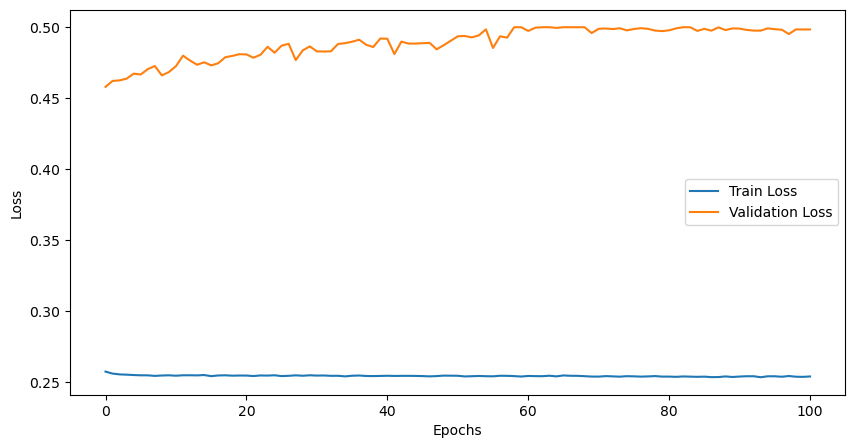

Evaluating model...


Evaluating: 100%|█████████████████████████████████████████████████████████████████| 282/282 [00:30<00:00,  9.30batch/s]


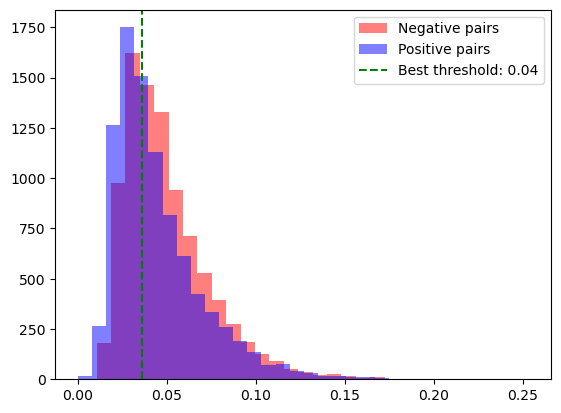

Best threshold: 0.03595321625471115
Evaluation completed!
Predicting random batch...


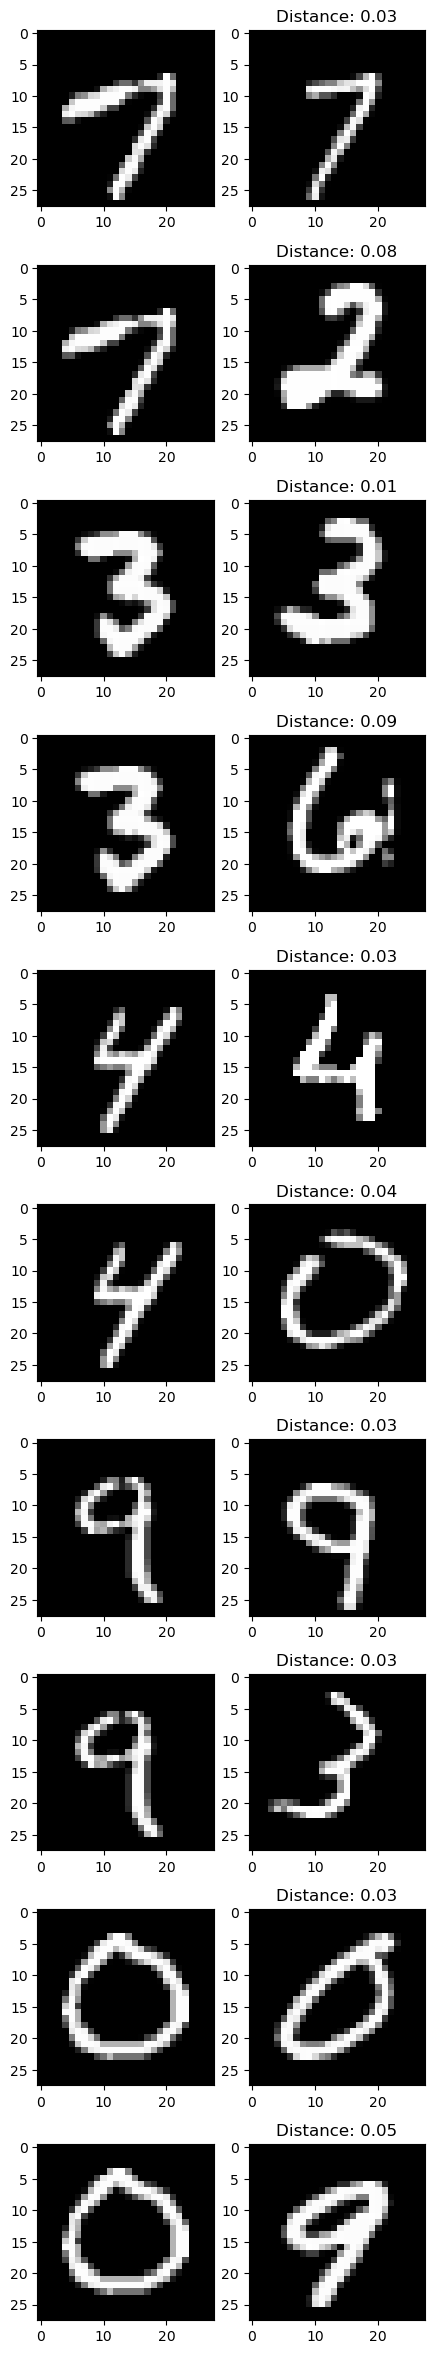

In [15]:
main(do_train="single")
#main(do_train="no")
#main(do_train="tune")